<a href="https://colab.research.google.com/github/Gaurav-phatkare/BERT_Model-NLP/blob/main/BERT_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT - Bidirectional Encoder Representations from Transformers
---
As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).


further explaination from [HuggingFace.co](https://huggingface.co/blog/bert-101?text=The+goal+of+life+is+%5BMASK%5D.)

##Skimlit Medical Abstract Classifier Using BERT Model Approach

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-039d7abb-4839-9450-a9e6-1e1368ba9460)


In [2]:
# !pip install tensorflow==2.9.1
import tensorflow as tf
print(tf.__version__)

2.13.0


In [2]:
# !pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation

In [3]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

###Get Data
[Dataset Link](https://github.com/Franck-Dernoncourt/pubmed-rct)


In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.83 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [6]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

###Preprocess the data

In [8]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [9]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [10]:
len(train_lines)

210040

In [11]:
def preprocess_text_with_line_number(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
       abstract_lines += line

  return abstract_samples

In [12]:
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [13]:
train_samples[:5], len(train_samples)

([{'target': 'OBJECTIVE',
   'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
   'line_number': 0,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 1,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 2,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'line_number': 3,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'secondary outcome measures included 

In [14]:
import pandas as pd
import numpy as np

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

###Convert to list

In [17]:
train_sentances = train_df['text'].tolist()
val_sentances = val_df['text'].tolist()
test_sentances = test_df['text'].tolist()

len(train_sentances), len(val_sentances), len(test_sentances)

(180040, 30212, 30135)

### Make Numeric Labels

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [22]:
# function for accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def calculate_results(y_true, y_pred):
  """
  calculate model acuracy, precision, recall and f1 score of a binary classification model
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculat model precision, recall and f1-score using weigthed average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average = 'weighted' )

  model_results = {

                   'accuracy' :model_accuracy,
                   'precision':model_precision,
                   'recall' : model_recall,
                   'f1' : model_f1
  }
  return model_results

In [23]:
from tensorflow.keras.layers import TextVectorization, Embedding

sent_len = [len(i.split()) for i in train_sentances]

In [24]:
sent_len[:5]

[49, 27, 15, 14, 35]

In [25]:
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

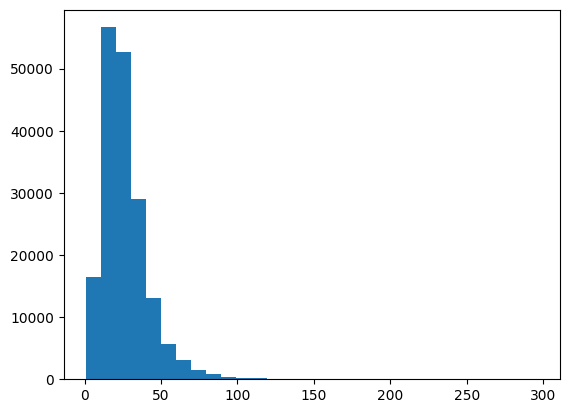

In [26]:
import matplotlib.pyplot as plt
plt.hist(sent_len, bins = 30)

In [27]:
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [28]:
max_tokens = 68000 #given in paper

In [29]:
text_vectorizer  = TextVectorization(max_tokens = max_tokens,
                                     output_sequence_length = output_seq_len)

In [30]:
# adapt text vectorizer to training sentance
text_vectorizer.adapt(train_sentances)

In [31]:
# words in training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [32]:
print(len(rct_20k_text_vocab))
print(rct_20k_text_vocab[:5])
print(rct_20k_text_vocab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 256,
    name = 'token_embedding'
)

In [34]:

# Test out text vectorizer and embedding on random sentances

import random
target_sentance = random.choice(train_sentances)

print(f'Target sentance:\n{target_sentance}\n\n')
print(f'Vectorized target sentance:\n{text_vectorizer([target_sentance])}\n\n')
print(f'shape of vectorized sentance:{text_vectorizer([target_sentance]).shape}\n\n')
print(f'embedded target sentance:\n{embedding(text_vectorizer([target_sentance]))}\n\n')
print(f'shape of embedded sentance:{embedding(text_vectorizer([target_sentance])).shape}')

Target sentance:
we suggest that these changes would enhance the cardioprotective properties of this lipoprotein .


Vectorized target sentance:
[[  43  420   28  111  146  495 1335    2 6826 1536    4   23 1038    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


shape of vectorized sentance:(1, 55)


embedded target sentance:
[[[ 0.01368965 -0.00982447  0.0013294  ...  0.04898183  0.02604539
   -0.0031422 ]
  [-0.04607676  0.02527237 -0.01850419 ...  0.01266586  0.02137574
    0.0039031 ]
  [-0.03856176 -0.00181655  0.03311035 ...  0.02663894 -0.0230324
   -0.00199123]
  ...
  [-0.03658595  0.03655895 -0.01549997 ...  0.04344196  0.00758307
    0.01779826]
  [-0.03658595  0.03655895 -0.01549997 ...  0.04344196  0.00758307
    0.01779826]
  [-0.03658595  0.03655895 -0.01549997 ...  0.04344196  0.00758307
    0.01779826]]

###Character Level Encoding

In [35]:
def split_character(text):
  return ' '.join(list(text))


In [36]:
train_chars = [split_character(sentences) for sentences in train_sentances]
val_chars = [split_character(sentences) for sentences in val_sentances]
test_chars = [split_character(sentences) for sentences in test_sentances]

In [37]:
train_chars

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [38]:
char_lens = [len(sentance) for sentance in train_sentances]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [39]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [40]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
# create char- level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = None,
                                    name = 'char_vectorizer')

In [42]:
# Adapt character char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [43]:
char_vocab = char_vectorizer.get_vocabulary()

In [44]:
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(57, ['', '[UNK]', 'e', 't', 'i'], ['|', '"', ']', '\\', '['])

###Character Level Embedding layer

In [45]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 56,
    name = 'char_embed'
)

In [46]:
# Test our character embedding layer

random_sent = random.choice(train_chars)


print(f"Characterized sentance : \n{random_sent}\n")
print(f"Len of sentance:{len(random_sent.split())}\n")
print(f"Embedded sentance : \n{char_vectorizer(random_sent)}\n")
print(f'len of embedded sentance(Preset): {len(char_vectorizer(random_sent))}\n')

print(f"embedded char sentance:\n{char_embedding(char_vectorizer(random_sent))}\n")
print(f"shape of embedded char sentance:{char_embedding(char_vectorizer(random_sent)).shape}")

Characterized sentance : 
w e   c o n d u c t e d   p o s t   h o c   (   s e c o n d a r y   )   a n a l y s e s   o f   u n p u b l i s h e d   d a t a   f r o m   a   p r e v i o u s l y   p u b l i s h e d   r a n d o m i z e d   c l i n i c a l   t r i a l   (   n c t @   )   o f   d e s m o p r e s s i n   (   a   m e d i c a t i o n   u s e d   t o   t r e a t   n o c t u r i a   )   a n d   e x a m i n e d   r e l a t i o n s h i p s   b e t w e e n   b a s e l i n e   a n d   @ - w e e k   c h a n g e   i n   f u s p   a n d   p s q i   g l o b a l   a n d   s u b s c a l e   s c o r e s   f o r   p a r t i c i p a n t s   (   n   =   @   t o   n   =   @   )   h a v i n g   c o m p l e t e   d a t a   .

Len of sentance:287

Embedded sentance : 
[21  2 11  7  6 10 16 11  3  2 10 14  7  9  3 13  7 11 28  9  2 11  7  6
 10  5  8 20 27  5  6  5 12 20  9  2  9  7 17 16  6 14 16 23 12  4  9 13
  2 10 10  5  3  5 17  8  7 15  5 14  8  2 22  4  7 16  9 12 20 14 16 23
 12  4  9 13  2 

### Positional Embedding layer

In [47]:
import tensorflow as tf
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)


In [48]:
train_line_number_one_hot[:5],

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,)

In [49]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5],

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,)

###Creating tribrid inputs
---
Prefetched Dataset

In [50]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentances, train_chars))

train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentances, val_chars))

val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [52]:
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                        test_total_line_number_one_hot,
                                                        test_sentances,
                                                        test_chars))

test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Building BERT Models

In [53]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [54]:
preprocess_layer = hub.KerasLayer(preprocess, name = 'bert_input_preprocess')
bert_layer = hub.KerasLayer(bert, name = 'bert_layer')

###Build a model

In [55]:
from tensorflow import keras
from tensorflow.keras import layers

In [56]:
#1. Token Inputs
token_inputs = layers.Input(shape=[], dtype = tf.string, name='token_inputs', ragged = False)
bert_input = preprocess_layer(token_inputs)
bert_outputs = bert_layer(bert_input, training = False)
sequence_output = bert_outputs['pooled_output']
token_outputs = layers.Dense(128, activation = 'relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)


# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer according to the paper
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)


# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])


# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)



In [57]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 bert_input_preprocess (Ker  {'input_type_ids': (None,    0         ['token_inputs[0][0]']        
 asLayer)                    128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                     

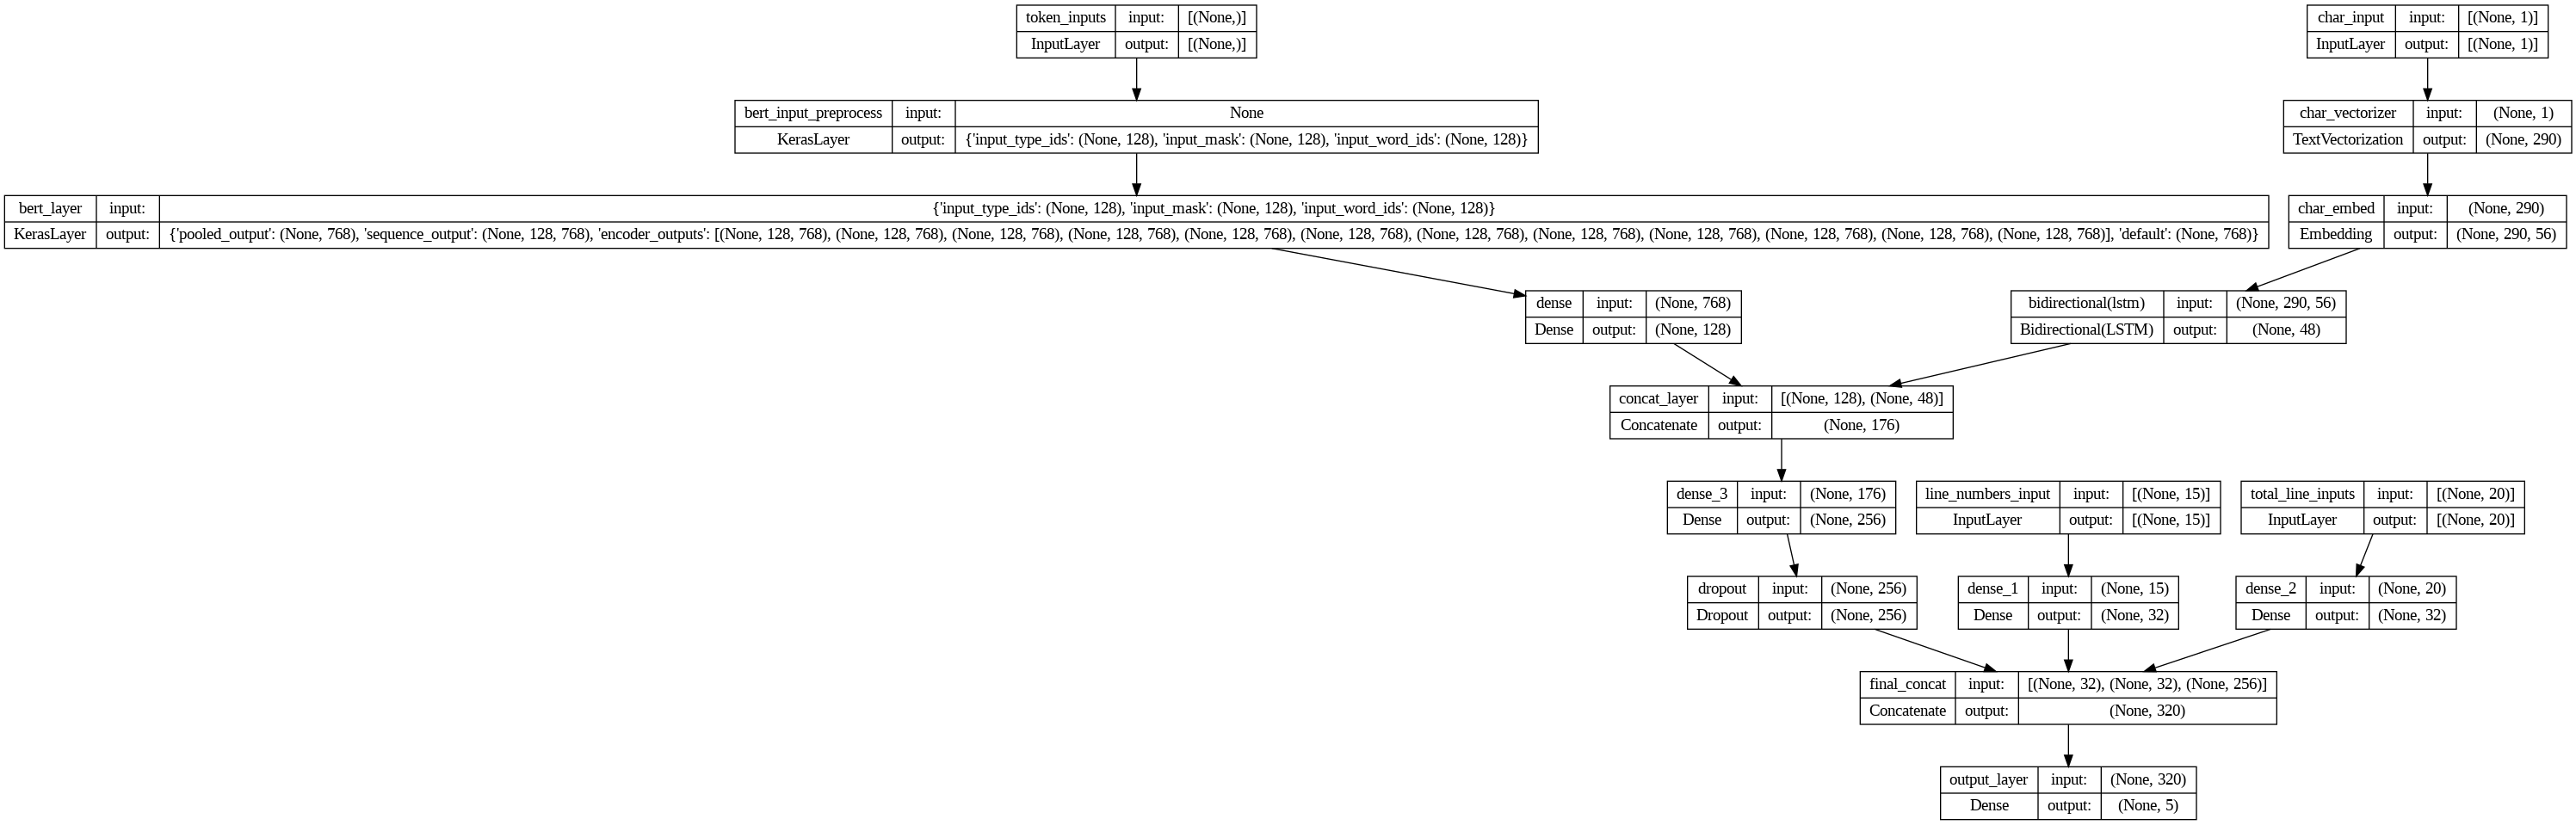

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

###Compile the model

In [59]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

In [ ]:
model_history = model.fit(
    train_tribrid_dataset,
    epochs = 6,
    steps_per_epoch = int(0.2 * len(train_tribrid_dataset)),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.2 * len(val_tribrid_dataset))
)

Epoch 1/6
1125/1125 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.8357